In [1]:
# !pip install spacy

# !pip install word2vec

# # Elementos a utilizar
import nltk

nltk.download("webtext")
from nltk.corpus import webtext

nltk.download("stopwords")

print("the data contained in the webtext is :", webtext.fileids())


the data contained in the webtext is : ['firefox.txt', 'grail.txt', 'overheard.txt', 'pirates.txt', 'singles.txt', 'wine.txt']


[nltk_data] Downloading package webtext to /home/dante/nltk_data...
[nltk_data]   Package webtext is already up-to-date!
[nltk_data] Downloading package stopwords to /home/dante/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# utilizar la información del webchat de firefox
firefox = webtext.raw("firefox.txt")
print(firefox[:500])

firefox_sents = firefox.split("\n")
print(
    "el número de frases convertidas a partir del fichero de datos brutos es de:",
    len(firefox_sents),
)


Cookie Manager: "Don't allow sites that set removed cookies to set future cookies" should stay checked
When in full screen mode
Pressing Ctrl-N should open a new browser when only download dialog is left open
add icons to context menu
So called "tab bar" should be made a proper toolbar or given the ability collapse / expand.
[XUL] Implement Cocoa-style toolbar customization.
#ifdefs for MOZ_PHOENIX
customize dialog's toolbar has small icons when small icons is not checked
nightly builds 
el número de frases convertidas a partir del fichero de datos brutos es de: 10002


In [3]:
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

In [4]:
# limpieza de los datos
Stopwords = stopwords.words("english")
import re

charfilter = re.compile("[a-zA-Z]+")

# tokenizar las palabras
def simple_filter(sent):
    # convertir todos los tokens a minúsculas:
    words = sent.split()
    word_lower = []
    for word in words:
        word_lower.append(word.lower())
    # eliminar todas las stopwords
    # eliminar caracteres
    tokens = list(filter(lambda token: charfilter.match(token), word_lower))
    # stemming de las palabras
    ntokens = []
    for word in tokens:
        ntokens.append(PorterStemmer().stem(word))
    return " ".join(tokens)


# convertir todos los datos de bryant a tokens utilizando nuestra función simple tokenizer
sentences = []
for sent in firefox_sents:
    tokens = simple_filter(sent)
    if len(tokens) > 0:
        sentences.append(tokens)


## Merge del primer codigo  on el segundo
Para hacer el merge del primer y segundo codigo, basicamente en el primer codigo hacemos la desambiguacion de las palabras, primero usando el etiquetado POS el cual nos agrega a la palabra si es un verbo, adjetivo, etc. Pero se hace la mejora usando el algoritmo de Lesk el cual tiene un conjunto de significados de una palabra, me explico: de la palabra "die" le encontramos diferentes significados, por ejemplo: 

- defination 0 : pass from physical life and lose all bodily attributes and functions necessary to sustain life 
- defination 1 : suffer or face the pain of death
- defination 2 : be brought to or as if to the point of death by an intense emotion such as embarrassment, amusement, or shame
- defination 3 : stop operating or functioning
- defination 4 : feel indifferent towards
- defination 5 : languish as with love or desire
- defination 6 : cut or shape with a die
- defination 7 : to be on base at the end of an inning, of a player
- defination 8 : lose sparkle or bouquet
- defination 9 : disappear or come to an end
- defination 10 : suffer spiritual death; be damned (in the religious sense)

Es decir son todos los significados que puede tener la palabra "die" en un contexto, el algoritmo Lesk nos ayuda a encontrar este significado, por ejemplo "space.n.08" donde a space es un noun con la definicion 8 y ya tiene la combinacion de usar la etiqueta POS con el algoritmo Lesk.

Tomamos el codigo de Lesk para aplicar la desambiguacion:

In [5]:
from nltk.corpus import wordnet as wn
from nltk.wsd import lesk
import warnings
from nltk import wsd

POS_MAP = {
    'VERB': wn.VERB,
    'NOUN': wn.NOUN,
    'PROPN': wn.NOUN
}

def lesk(doc, word):
    found = False
    for token in doc:
        if token.text == word:
            word = token
            found = True
            break
    if not found:
        raise ValueError(f'Word \"{word}\" No aparece en el documentos: {doc.text}.')
    pos = POS_MAP.get(word.pos_, False)
    if not pos:
        warnings.warn(f'POS tag para {word.text} no encontrada en wordnet. Volver al comportamiento por defecto de Lesk.')
    args = [c.text for c in doc], word.text
    kwargs = dict(pos=pos)
    return wsd.lesk(*args, **kwargs)


Ahora hace falta pasalor a las ahoraciones que teniamos, donde si revisamos el codigo anterior toamamos las oraciones, les hacemos limpieza y las dividimos en oraciones y depues las tokenizamos entonces tenemos cada palabra de la oracion, esto es lo que necesitamos para el algoritmo Lesk, es decir el contexto (la oracion) y cada una de las palabras (tokenizacion), lo hacemos del siguiente modo:

In [6]:
# Sense2Vec
# usar Spacy para calcular las etiquetas de POS de cada palabra
import spacy

nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

sense_corpus = []
for item in sentences:
    doc = nlp(item)
    sense_sentence = []
    for token in doc:
        sense = lesk(doc, token.text)
        if sense is not None:
            sense_sentence.append(sense.name())
        else:
            sense_sentence.append(token.text)
    sense_corpus.append(sense_sentence)

/tmp/ipykernel_99914/2640211677.py:23: UserWarning: POS tag para : no encontrada en wordnet. Volver al comportamiento por defecto de Lesk.
  warnings.warn(f'POS tag para {word.text} no encontrada en wordnet. Volver al comportamiento por defecto de Lesk.')
/tmp/ipykernel_99914/2640211677.py:23: UserWarning: POS tag para that no encontrada en wordnet. Volver al comportamiento por defecto de Lesk.
  warnings.warn(f'POS tag para {word.text} no encontrada en wordnet. Volver al comportamiento por defecto de Lesk.')
/tmp/ipykernel_99914/2640211677.py:23: UserWarning: POS tag para to no encontrada en wordnet. Volver al comportamiento por defecto de Lesk.
  warnings.warn(f'POS tag para {word.text} no encontrada en wordnet. Volver al comportamiento por defecto de Lesk.')
/tmp/ipykernel_99914/2640211677.py:23: UserWarning: POS tag para future no encontrada en wordnet. Volver al comportamiento por defecto de Lesk.
  warnings.warn(f'POS tag para {word.text} no encontrada en wordnet. Volver al compo

Algunas palabras no se encuentran, es normal. Ahora podemos ver como queda nuestras sentencias: 

In [18]:
sense_corpus

[['cookie.n.03',
  'director.n.01',
  ':',
  'give_up.v.11',
  'web_site.n.01',
  'that',
  'set.v.08',
  'take_out.v.01',
  'cookie.n.03',
  'to',
  'set.v.08',
  'future.n.02',
  'cookie.n.03',
  '"',
  'should',
  'stay.v.02',
  'see.v.10'],
 ['when', 'indium.n.01', 'wax.v.03', 'screen.n.05', 'mood.n.03'],
 ['press.v.10',
  'ctrl',
  '-',
  'nitrogen.n.01',
  'should',
  'unfold.v.04',
  'deoxyadenosine_monophosphate.n.01',
  'newfangled.s.01',
  'browser.n.02',
  'when',
  'only.r.06',
  'download',
  'dialogue.n.03',
  'embody.v.02',
  'leave.v.11',
  'unfold.v.04'],
 ['total.v.02', 'picture.n.01', 'to', 'context', 'menu.n.04'],
 ['thus.r.02',
  'name.v.01',
  'stripe.n.05',
  '"',
  'should',
  'be.v.03',
  'make.v.42',
  'vitamin_a.n.01',
  'proper.s.04',
  'toolbar',
  'oregon.n.01',
  'yield.v.01',
  'the',
  'ability.n.01',
  'crash.n.03',
  'expand',
  '.'],
 ['implement.v.01',
  'cocoa.n.01',
  '-',
  'vogue.n.01',
  'toolbar',
  'customization',
  '.'],
 ['for', 'moz_phoen

In [8]:
# Ahora, utilizar el modelo word2vec en el corpus de sentidos creado
from gensim.test.utils import common_texts
from gensim.models import Word2Vec

In [9]:
# Los modelos colocados como comentarios son distintas formas de generar el modelado
model_skipgram = Word2Vec(
    sense_corpus, min_count=1, vector_size=50, workers=3, window=5, sg=1
)
# model_w2v = Word2Vec(sense_corpus,vector_size=200)
# model_skipgram  = Word2Vec(sentences=sense_corpus, vector_size=100, window=5, min_count=1, workers=4)

model_skipgram

In [10]:
import warnings

warnings.filterwarnings("ignore")

# Ahora, utilizar el modelo word2vec en el corpus de sentidos creado
from gensim.models import Word2Vec
model_skipgram = Word2Vec(
    sense_corpus, min_count=1, vector_size=50, workers=3, window=5, sg=1
)

# Configura los hiperparámetros del modelo
model = Word2Vec(
    sentences=sense_corpus, vector_size=100, window=5, min_count=1, sg=0, workers=4
)

# Entrena el modelo
model.train(sense_corpus, total_examples=model.corpus_count, epochs=100)

(7326490, 8990000)

Si queremos encontrar las palabras similare,s debemos cambiar el como se encuentrana ahora, puse el achivo de busqueda.txt para que pegais las palabras y las busqueis como estan ahora

In [11]:
"""Observar la similitud entre palabras, web o internet por ejemplo"""

similar_words = model.wv.most_similar("internet.n.01", "web.n.06")
print(similar_words)

[('exercise.v.03', 0.46153298020362854), ('internet_explorer.n.01', 0.44807639718055725), ('port.v.01', 0.40679794549942017), ('give.v.43', 0.40302610397338867), ('up.r.05', 0.39083972573280334), ('conflicing', 0.390753835439682), ('machine.n.01', 0.3898971974849701), ('integration.n.03', 0.3888862729072571), ('dell.n.01', 0.38726648688316345), ('extention', 0.3853917717933655)]


In [12]:
similar_words = model.wv.most_similar("web.n.06", topn=3)
print(similar_words)

[('unlimited.a.01', 0.4930671751499176), ('defender.n.01', 0.4645673632621765), ('preferences->advanced->images', 0.4559687077999115)]


In [13]:
# Suponiendo que tienes un modelo Word2Vec entrenado con skip-gram
from gensim.models import Word2Vec

# Acceder al vocabulario
vocab = model_skipgram.wv.key_to_index

# Verificar si una palabra está en el vocabulario
if "web.n.06" in vocab:
    print("La palabra 'web.n.06' está en el vocabulario.")
else:
    print("La palabra 'ejemplo' no está en el vocabulario.")

La palabra 'web.n.06' está en el vocabulario.


In [14]:
# Obtener el vector de una palabra
vector = model_skipgram.wv["web.n.06"]
print("Vector de la palabra 'web.n.06':", vector)

Vector de la palabra 'web.n.06': [ 0.04621781  0.06071093 -0.08897816  0.09024175 -0.07494006 -0.45032853
  0.4181103   0.3711107  -0.35853755 -0.15565342 -0.07813318 -0.34521613
  0.25604102  0.19457088 -0.06514183  0.07183498  0.27696088  0.23256452
 -0.66886353 -0.4890158   0.09527323  0.222174    0.7085349  -0.04075312
  0.27380347  0.23518547 -0.36745197 -0.09294366 -0.26104182  0.1893286
  0.16435595 -0.06023418  0.16487244 -0.09426917 -0.25149757  0.32772505
  0.21057096  0.05839225  0.08441439 -0.05926063  0.47978184  0.05076727
 -0.23086116 -0.12771559  0.5601865   0.02995777 -0.15412508 -0.3444608
  0.24024384  0.10780147]


In [15]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Suponiendo que se tiene un modelo Word2Vec entrenado
from gensim.models import Word2Vec

# Cargar o entrenar el modelo

# Obtener los vectores de palabras y sus etiquetas
words = []
vectors = []
for word in model_skipgram.wv.key_to_index:
    words.append(word)
    vectors.append(model_skipgram.wv[word])

# Realizar reducción de dimensionalidad con PCA
pca = PCA(n_components=2)
vectors_2d = pca.fit_transform(vectors)

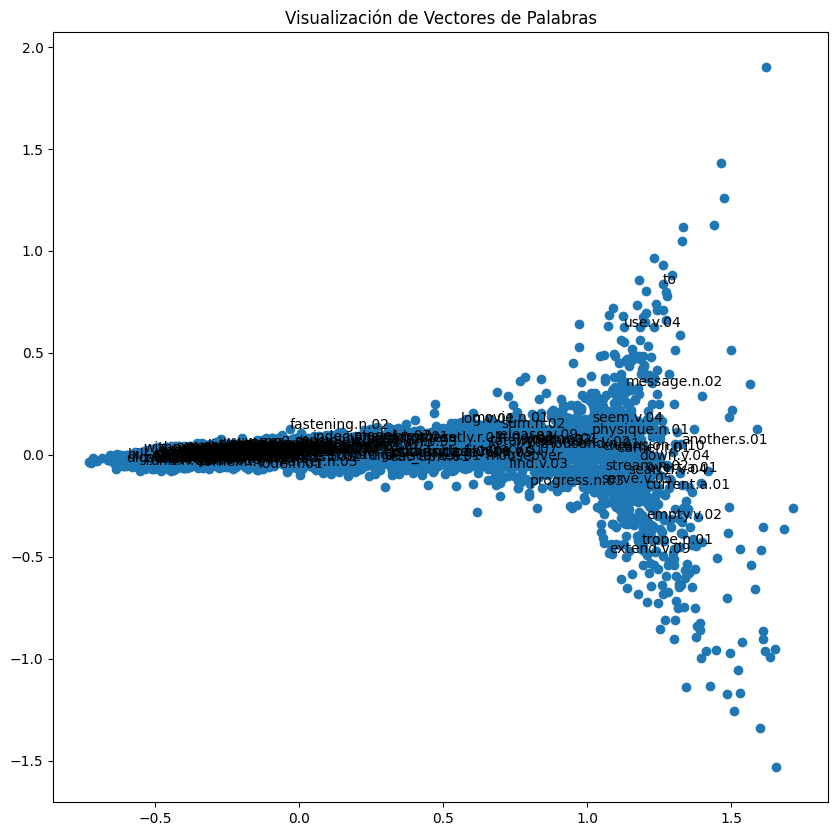

In [16]:
# Alternativamente, puedes usar t-SNE para una mejor visualización
# t-SNE suele funcionar mejor que PCA para visualizar en 2D
# t-SNE puede tardar más en ejecutarse
# tsne = TSNE(n_components=2)
# vectors_2d = tsne.fit_transform(vectors)

# Crear un gráfico de dispersión para visualizar los vectores de palabras
plt.figure(figsize=(10, 10))
plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1])

# Etiquetar algunos puntos en el gráfico para palabras específicas
for i, word in enumerate(words):
    if i % 50 == 0: 
        plt.annotate(word, (vectors_2d[i, 0], vectors_2d[i, 1]))

plt.title("Visualización de Vectores de Palabras")
plt.show()

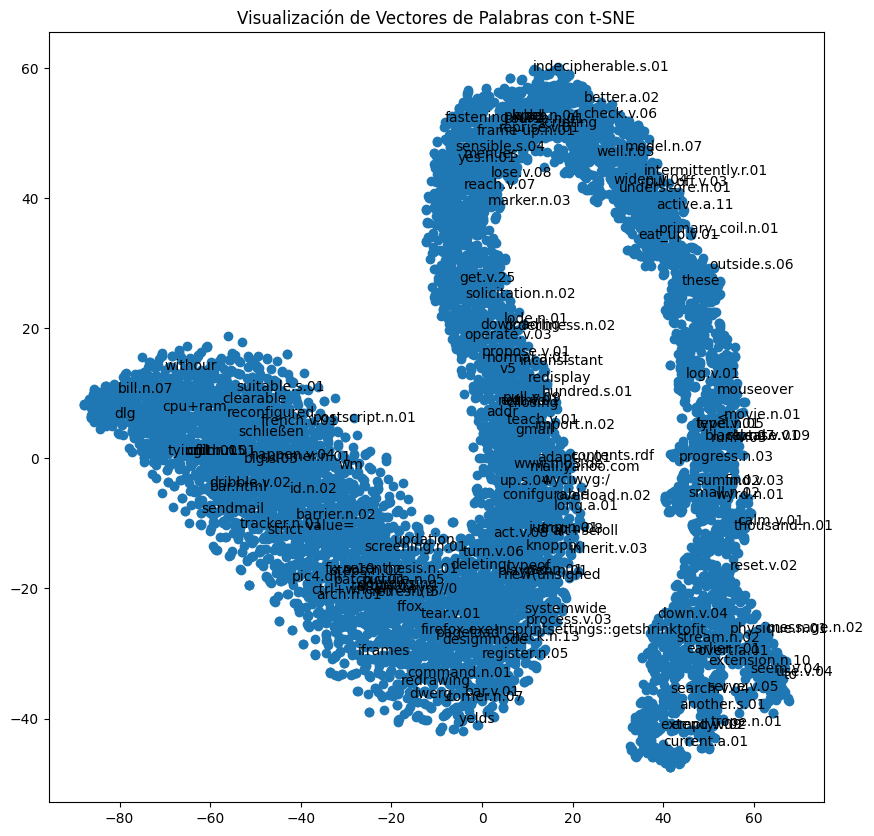

In [17]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Suponiendo que tienes un modelo Word2Vec entrenado
from gensim.models import Word2Vec

# Cargar o entrenar el modelo

# Obtener los vectores de palabras y sus etiquetas
words = []
vectors = []
for word in model_skipgram.wv.key_to_index:
    words.append(word)
    vectors.append(model_skipgram.wv[word])

# Convertir la lista de listas a un arreglo NumPy
vectors = np.array(vectors)

# Realizar reducción de dimensionalidad con t-SNE
tsne = TSNE(n_components=2, random_state=42)
vectors_2d = tsne.fit_transform(vectors)

# Crear un gráfico de dispersión para visualizar los vectores de palabras
plt.figure(figsize=(10, 10))
plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1])

# Etiquetar algunos puntos en el gráfico para palabras específicas
for i, word in enumerate(words):
    if i % 50 == 0:
        plt.annotate(word, (vectors_2d[i, 0], vectors_2d[i, 1]))

plt.title("Visualización de Vectores de Palabras con t-SNE")
plt.show()
